# Chapter Companion — Scalar Mixing

**Book:** *Principles of Turbulence: An Introduction with Python Computations*  
**Chapter:** 3 — Scalar Mixing  
**Author:** Prof. Kiran Bhaganagar  
**Last updated:** (auto/you)

> This notebook follows the chapter and provides runnable code aligned to each section.


# Table of Contents

- [Chapter Companion — Scalar Mixing](#chapter-companion--scalar-mixing)
  - [3.1. Learning Goals](#learning-goals)
  - [3.2. Key Equations — Scalar Mixing](#key-equations--scalar-mixing)
  - [3.3. Initialization](#binning--indices)
  - [3.4. Synthetic Data](#data-in--synthetic-data)
  - [3.5. Add Noise and Save CSV](#loading--preparing-data)
  - [3.6.Example  NB 3.1: Visualizing mean, flux, variance, and eddy diffusivity](#core-computations)
  - [3.7. Example NB 3.2 : Scalar dissipation (χ) and variance production (P)](#calculating-scalar-flux)
  - [3.8. Example NB 3.3: Demo for shear-mixing with eddy viscosity](#mean-profiles)
  - [3.9 Example  NB 3.4 Van Driest damped mixing length](#visualizations)
  - [3.10 Example NB 3.5: Solve Scalar Diffusion Equation](#guided-exercises)
  - [3.11 Example NB 3.6. — Buoyancy & Shear Demo (stability vs eddy mixing)](#guided-exercises)
  - [3.12 Example NB 3.7: Density Currents](#quick-checks)
  - [3.13 Example NB 3.8: Eddy mixing time scale](#quick-checks)
  - [3.14 Homework Problems](#core-computation)
 

<a id="intro"></a>
## 3.1. Learning Goals

1. Write and interpret the advection–diffusion equation for a passive scalar \(c\).
2. Compute scalar flux \( \langle v'c' \rangle \), scalar variance \( \langle c'^2 \rangle \), and a dissipation proxy \( \chi \).
3. Estimate eddy diffusivity \( K_t \) from data and visualize profiles.
4. Compare production vs. dissipation trends and discuss closures.



## 3.2. Key Equations — Scalar Mixing
### Instantaneous advection–diffusion:
$$
   \frac{\partial c}{\partial t} + u_j \frac{\partial c}{\partial x_j} = D \frac{\partial^2 c}{\partial x_j \partial x_j} \
$$
   
### Mean transport (1D in \(y\)) and gradient–diffusion closure:
$$
 \frac{\partial \langle c \rangle}{\partial t}
     + \frac{\partial}{\partial y}\Big( \langle v' c' \rangle - D \frac{\partial \langle c \rangle}{\partial y} \Big) = 0, \quad
     \langle v' c' \rangle \approx -K_t \frac{\partial \langle c \rangle}{\partial y} 
$$
#### Scalar variance and dissipation proxy:
  $$
  \langle c'^2 \rangle, \quad \chi \equiv 2D\,\langle \nabla c' \cdot \nabla c' \rangle 
$$

#### Eddy diffusivity and turbulent Schmidt number (optional):
$$
 K_t \approx -\frac{\langle v' c' \rangle}{\partial \langle c \rangle/\partial y}, \quad \mathrm{Sc}_t = \frac{\nu_t}{K_t} 
$$
#
$$
\frac{\partial \phi}{\partial t} = \mu \frac{\partial^2 \phi}{\partial x^2}
\label{eq:fick}
$$


%% ---------------- Turbulent-mean transport with eddy diffusivity ----------------
#### Reynolds-mean scalar transport (angle brackets = mean)
$$
\frac{\partial \langle c \rangle}{\partial t}
\;+\; \langle \mathbf{u} \rangle \!\cdot \nabla \langle c \rangle
\;+\; \nabla\!\cdot\langle \mathbf{u}'\,c' \rangle
\;=\; D\,\nabla^2 \langle c \rangle .
$$

#### Gradient–diffusion closure for turbulent scalar flux
$$
\langle \mathbf{u}'\,c' \rangle \;\approx\; -\,K_t \,\nabla \langle c \rangle ,
\qquad
K_t \;=\; \frac{\nu_t}{\mathrm{Sc}_t}
\quad\text{(species; for heat: }\ \kappa_t=\nu_t/\mathrm{Pr}_t\text{)} .
$$

#### Closed mean transport equation
$$
\frac{\partial \langle c \rangle}{\partial t}
\;+\; \langle \mathbf{u} \rangle \!\cdot \nabla \langle c \rangle
\;=\; \nabla\!\cdot\!\Big[\,(D + K_t)\,\nabla \langle c \rangle \Big] .
$$

#### 1D wall-normal (y) flux with eddy diffusivity
$$
\langle j_{c,y} \rangle
\;=\; -\,(D + K_t)\,\frac{\partial \langle c \rangle}{\partial y} .
\]
\sim \frac{L^2}{\mu}.
\label{eq:diffusion-timescale}
$$

$$
\overline{q}(t) = \frac{1}{T}\int_{t}^{t+T} q(\tau)\,d\tau ,
\label{eq:longtimemeandef}
$$


$$
\langle q(t) \rangle \;=\; \lim_{N \to \infty} \frac{1}{N}\sum_{n=1}^{N} q^{(n)}(t),
\label{eq:ensembleavg}
$$


$$
q(t) = \overline{q} + q'(t), \qquad \overline{q'}=0 .
\label{eq:Reynolddecomdef}
$$


#### 3.3. Initialization
**Learning goal:** Map samples to bins.

**Explanation:** Create uniform bin edges in \(y\) and safe indices so edge values don't overflow.


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider
import sys, os
import ch3_scalar_mixing as ch3
import scalar_mixing_utils as smu
sys.path += ['/mnt/data', '/mnt/data/turbulence_book_companion', '/mnt/data/turbulence_book_companion/common']
try:
    import ch_scalar_mixing as sm
except Exception:
    try:
        from common import ch_scalar_mixing as sm
    except Exception:
        sm = None

# Fallbacks if module not available
def _bin_mean_fallback(x, y, bins):
    x = np.asarray(x); y = np.asarray(y); bins = np.asarray(bins)
    idx = np.digitize(y, bins) - 1
    out = np.full(len(bins)-1, np.nan)
    for k in range(len(out)):
        sel = idx == k
        if np.any(sel): out[k] = np.mean(x[sel])
    return out

bin_mean = sm.bin_mean if (sm is not None and hasattr(sm,'bin_mean')) else _bin_mean_fallback
bin_grad = sm.bin_grad if (sm is not None and hasattr(sm,'bin_grad')) else (lambda f,c: np.gradient(f,c))
scalar_flux_bin = sm.scalar_flux_bin if (sm is not None and hasattr(sm,'scalar_flux_bin')) else None
estimate_Kt = sm.estimate_Kt if (sm is not None and hasattr(sm,'estimate_Kt')) else (lambda vc,dc: -np.asarray(vc)/np.maximum(np.asarray(dc),1e-10))
chi_proxy_bin = sm.chi_proxy_bin if (sm is not None and hasattr(sm,'chi_proxy_bin')) else None
np.random.seed(7)
pd.set_option('display.precision', 4)


## 3.4.  Synthetic Data

### Creating Synthetic Data
**Learning goal:** Prepare scalar-mixing data.

**Explanation:** Construct or load the scalar field and companion variables on a consistent grid for analysis.


- $$
\text{Grid & constants: } N=3000,\ y\in[0,1],\ \mathrm{Pr}_t=0.9,\ \ell_m(y)=0.1\,y,\ 
\frac{dU}{dy}=20\,e^{-y/0.3},\ \frac{dT}{dy}=-30(1-y).
$$

- $$
\text{Mean fields (toy channel): }\ 
\rho(y)=1.2-0.1y,\quad
\overline{u}(y)=10\big(1-(y-0.5)^2\big),\quad
\overline{v}=0,\quad
\overline{T}(y)=300+40y.
$$

- $$
\text{Scalar mean with constant gradient: }\ 
\overline{c}(y)=0.2 + \underbrace{1.0}_{d\overline{c}/dy}\,y
\ \Rightarrow\ \frac{d\overline{c}}{dy}=1\ \text{(easy }K_t\text{ check)}.
$$

- $$
\text{Prescribe fluctuation amplitudes: }\ 
u_{\mathrm{rms}}=0.8+0.3y,\ \ v_{\mathrm{rms}}=0.4,\ \ T_{\mathrm{rms}}=3+1.0y;
\ \text{draw } u',v',T' \sim \mathcal{N}(0,\cdot).
$$

- $$
\text{Target eddy diffusivity (center-peaked): }\ 
K_t^{\text{true}}(y)=0.05+0.15\Big(1-(y-0.5)^2\Big)
\ \Rightarrow\ 
\langle v'c'\rangle_{\text{target}}
= -\,K_t^{\text{true}}\ \frac{d\overline{c}}{dy}
= -\,K_t^{\text{true}}.
$$

- $$
\text{Enforce the target flux by correlating } c' \text{ with } v':
\quad c'=\alpha\,v' + \text{noise},\ 
\text{choose }\alpha=\frac{\langle v'c'\rangle_{\text{target}}}{\langle v'^2\rangle}
=\frac{-K_t^{\text{true}}}{v_{\mathrm{rms}}^2}.
$$

- $$
\text{Assemble the scalar: } c(y)=\overline{c}(y)+c'(y),\ 
\text{and pack } \{y,\rho,u,v,T,c\} \text{ into a DataFrame for later binning/analysis.}
$$

**Why this setup?**  
$$
\text{By fixing } \frac{d\overline{c}}{dy}=1 \text{ and constructing } \langle v'c'\rangle=-K_t^{\text{true}},
\ \text{the gradient–diffusion estimate } 
K_t^{(\text{GD})}=-\frac{\langle v'c'\rangle}{d\overline{c}/dy}
\text{ should recover } K_t^{\text{true}} \text{ (up to sampling noise).}
$$

### $$ \text{How to obtain the target} K_t(y) $$

- $$
\text{Design goal: pick a simple, smooth, positive } K_t(y) \text{ that is larger in the core and smaller near the walls (as in channel flows).}
$$

- $$
\text{Simplest center-peaked shape on } y\in[0,1]:\ 
\phi(y)=1-\big(y-\tfrac12\big)^2
\quad\Rightarrow\quad
\phi(0)=\phi(1)=\tfrac34,\ \ \phi(\tfrac12)=1.
$$

- $$
\text{Scale and offset to set magnitudes: }\ 
K_t(y)=K_{\min}+K_{\text{amp}}\,\phi(y)
\ =\ K_{\min}+K_{\text{amp}}\Big[1-(y-\tfrac12)^2\Big].
$$

- $$
\text{In the notebook we used } K_{\min}=0.05,\ K_{\text{amp}}=0.15,\ 
\Rightarrow\ 
K_t(y)=0.05+0.15\Big[1-(y-\tfrac12)^2\Big],
\ \text{so } K_t \in [0.1625,\,0.20] \text{ across } y\in[0,1].
$$

- $$
\text{Why this form? }\ 
\underbrace{K_t \propto u'_{\mathrm{rms}}\,\ell_m}_{\text{mixing-length idea}}
\ \text{with } \ell_m \sim \kappa\,y(1-y)\ \text{(two-wall)},\ 
u'_{\mathrm{rms}} \ \text{moderate in the core} 
\ \Rightarrow\ \text{a **core-peaked** }K_t\text{ is expected.}
$$

- $$
\text{Practical reasons: }\ 
\text{(i) positive by construction, (ii) very smooth for finite differences, (iii) easy to tune }(K_{\min},K_{\text{amp}}).
$$

---

### Alternatives you can swap in

- $$
\text{Two-wall mixing-length proxy: } 
K_t(y)=C_\mu\,\kappa\,U_\ast\,y(1-y),
\ \text{ choose } C_\mu, U_\ast \text{ to match your scale.}
$$

- $$
\text{Cosine bump: }
K_t(y)=K_{\min}+K_{\text{amp}}\cos^2\!\big(\pi(y-\tfrac12)\big)
\ \text{(also core-peaked, periodic derivatives).}
$$

- $$
\text{Data-scaled: }
K_t(y)=C\,u'_{\mathrm{rms}}(y)\,\ell_m(y)
\ \text{ with } C \text{ fitted by least squares to a reference } K_t.
$$

---

In [62]:
# Synthetic channel-like dataset with scalar
import numpy as np
import pandas as pd
N = 3000
y = np.linspace(0,1, N)
Pr_t = 0.9
lm   = 0.1*y
dUdy = 20.0*np.exp(-y/0.3)
dTdy = -30.0*(1 - y)
# Mean fields
rho = 1.2 - 0.1*y
u_mean = 10*(1 - (y-0.5)**2)
v_mean = np.zeros_like(y)
T_mean = 300 + 40*y

# Scalar mean with constant gradient (for easy K_t estimate)
dcdyd = 1.0  # constant mean gradient d\bar{c}/dy
c_mean = 0.2 + dcdyd * y

# Fluctuation amplitudes
urms = 0.8 + 0.3*y
vrms = 0.4*np.ones_like(y)
Trms = 3 + 1.0*y

# Generate velocity fluctuations
u = u_mean + urms*np.random.randn(N)
v = v_mean + vrms*np.random.randn(N)
T = T_mean + Trms*np.random.randn(N)

# Correlated scalar fluctuations to enforce a target flux profile
# Target eddy diffusivity profile (toy)
Kt_true = 0.05 + 0.15*(1 - (y-0.5)**2)  # larger in center
# Desired flux: -K_t d\bar c/dy
target_flux = -Kt_true * dcdyd

# Build c' as linear function of v' to match <v'c'> plus some noise
eta = np.random.randn(N)
alpha = target_flux / np.maximum(vrms**2, 1e-8)  # so that <v'*(alpha v')> ≈ alpha*vrms^2 = target_flux
c_fluc = alpha*(v - np.mean(v)) + 0.2*eta  # add noise so variance isn't degenerate
c = c_mean + c_fluc

# Package
df = pd.DataFrame(dict(y=y, rho=rho, u=u, v=v, T=T, c=c))
df.head()

,y,rho,u,v,T,c
0,0.0000,1.2000,8.8524,0.6881,297.0755,-0.5541
1,0.0003,1.2000,7.1305,0.0569,296.4957,0.1610
2,0.0007,1.1999,7.5329,0.0134,297.7152,-0.2118
3,0.0010,1.1999,7.8361,-0.5042,298.1008,0.9150
4,0.0013,1.1999,6.8819,0.1241,299.0993,-0.0143


#### 3.5.  Add Noise and Save CSV
**Learning goal:** Load or synthesize the dataset.

**Explanation:** Create/align arrays \(y,u,v,c\) and ensure consistent lengths; sort by \(y\) for stable binning.


In [63]:
# Add noise & save CSV
rng=np.random.default_rng(42); nl=0.03
lm_n=lm*(1+nl*rng.standard_normal(lm.shape)); dUdy_n=dUdy*(1+nl*rng.standard_normal(dUdy.shape)); dTdy_n=dTdy*(1+nl*rng.standard_normal(dTdy.shape))
nu_t_n=(lm_n**2)*np.abs(dUdy_n); kappa_t_n=nu_t_n/Pr_t; q_y_n=-kappa_t_n*dTdy_n; P_theta_n=2.0*kappa_t_n*(dTdy_n**2)
syn=pd.DataFrame({"y":y,"lm_m":lm_n,"S_1_per_s":dUdy_n,"Pr_t":Pr_t,"nu_t_m2_per_s":nu_t_n,"kappa_t_m2_per_s":kappa_t_n,
                  "dTdy_K_per_m":dTdy_n,"q_y_K_m_per_s":q_y_n,"P_theta_K2_per_s":P_theta_n})
syn.to_csv("Synthetic_ShearDemo.csv", index=False); print("Saved Synthetic_ShearDemo.csv"); syn.head()

Saved Synthetic_ShearDemo.csv


,y,lm_m,S_1_per_s,Pr_t,nu_t_m2_per_s,kappa_t_m2_per_s,dTdy_K_per_m,q_y_K_m_per_s,P_theta_K2_per_s
0,0.0000,0.0000e+00,20.7494,0.9,0.0000e+00,0.0000e+00,-30.2026,0.0000e+00,0.0000e+00
1,0.0003,3.2304e-05,20.3899,0.9,2.1278e-08,2.3642e-08,-29.9420,7.0790e-07,4.2392e-05
2,0.0007,6.8190e-05,21.1326,0.9,9.8265e-08,1.0918e-07,-30.7571,3.3582e-06,2.0657e-04
3,0.0010,1.0286e-04,19.0078,0.9,2.0109e-07,2.2343e-07,-30.5155,6.8182e-06,4.1612e-04
4,0.0013,1.2557e-04,19.7528,0.9,3.1146e-07,3.4607e-07,-27.2763,9.4395e-06,5.1495e-04


## Examples


#### 3.6. Example NB3.1: Visualizing mean, flux, variance, and eddy diffusivity

**Learning goal:** Convert raw samples \((y,u,v,c)\) into bin-averaged diagnostics and visualize
 $$\text{mean scalar: } \langle c\rangle(y)$$,
 $$\text{turbulent scalar flux: } \langle v'c'\rangle(y)\ $$ 
 $$ \text{eddy diffusivity estimate: } K_t(y) $$.

**What the cell does**

- **Build bins and safe indices**
  $$
  \text{bins}=\{\ y_0,\dots,y_{N_b}\ \},\quad
  \text{centers}=\tfrac12(\text{bins}_{k}+\text{bins}_{k+1}),\quad
  \text{idx}=\mathrm{clip}\!\big(\mathrm{searchsorted}(\text{bins},y)-1,\ 0,\ N_b-1\big).
  $$

- **Bin means**
  $$
  \langle c\rangle_k=\mathrm{mean}\{\,c_i:\ \text{idx}_i=k\,\},\quad
  \langle u\rangle_k,\ \langle v\rangle_k\ \text{analogously.}
  $$

- **Local fluctuations (relative to each bin’s mean)**
  $$
  c'_i = c_i - \langle c\rangle_{\text{idx}_i},\quad
  u'_i = u_i - \langle u\rangle_{\text{idx}_i},\quad
  v'_i = v_i - \langle v\rangle_{\text{idx}_i}.
  $$

- **Bin flux and variance**
  $$
  \langle v'c'\rangle_k=\mathrm{mean}\{\,v'_i c'_i:\ \text{idx}_i=k\,\},\qquad
  \langle c'^2\rangle_k=\mathrm{mean}\{\,{c'_i}^2:\ \text{idx}_i=k\,\}.
  $$

- **Mean scalar gradient (on bin means)**
  $$
  \Big(\partial_y\langle c\rangle\Big)_k \approx
  \frac{\langle c\rangle_{k+1}-\langle c\rangle_{k-1}}{\text{centers}_{k+1}-\text{centers}_{k-1}}.
  $$

- **Eddy diffusivity (gradient–diffusion closure)**
  $$
  K_t(k)\;\approx\;-\frac{\langle v'c'\rangle_k}{\big(\partial_y\langle c\rangle\big)_k},
  \qquad \text{with a small floor on the denominator for stability.}
  $$

**Plots produced**
 $$\langle c\rangle(y) $$



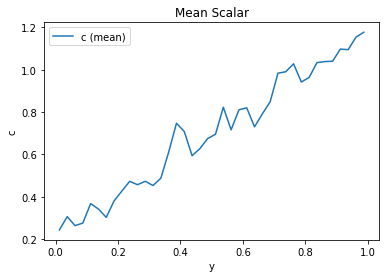

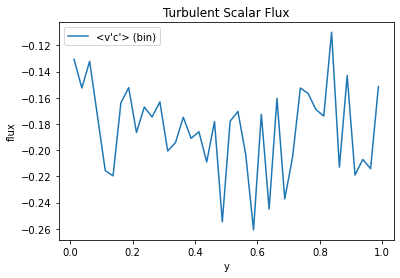

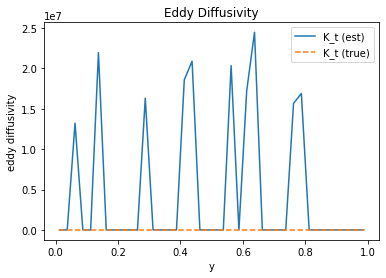

In [64]:
from ch_scalar_mixing import bin_mean, bin_grad, estimate_Kt

num_bins = 40
bins = np.linspace(y.min(), y.max(), num_bins + 1)
centers = 0.5*(bins[:-1]+bins[1:])
idx = np.searchsorted(bins, y, side='right') - 1
idx = np.clip(idx, 0, len(bins) - 2) 


# Bin means
c_re_b = bin_mean(c, y, bins)
u_re_b = bin_mean(u, y, bins)
v_re_b = bin_mean(v, y, bins)

# Fluctuations around bin means
c_p_loc = c - c_re_b[idx]
u_p_loc = u - u_re_b[idx]
v_p_loc = v - v_re_b[idx]

# Flux and variance per bin
vc_b = bin_mean(v_p_loc*c_p_loc, y, bins)
cvar_b = bin_mean(c_p_loc*c_p_loc, y, bins)

# Mean scalar gradient per bin (finite difference of bin-mean c)
dc_dy_b = np.gradient(c_re_b, centers)

# Eddy diffusivity estimate
Kt_est = -vc_b / np.maximum(dc_dy_b, 1e-8)

# Plots
fig = plt.figure(figsize=(6,4))
plt.plot(centers, c_re_b, label="c (mean)")
plt.xlabel("y"); plt.ylabel("c"); plt.title("Mean Scalar"); plt.legend(); plt.show()

fig = plt.figure(figsize=(6,4))
plt.plot(centers, vc_b, label="<v'c'> (bin)")
plt.xlabel("y"); plt.ylabel("flux"); plt.title("Turbulent Scalar Flux"); plt.legend(); plt.show()

fig = plt.figure(figsize=(6,4))
plt.plot(centers, Kt_est, label="K_t (est)")
plt.plot(centers, 0.05 + 0.15*(1 - (centers-0.5)**2), label="K_t (true)", linestyle="--")
plt.xlabel("y"); plt.ylabel("eddy diffusivity"); plt.title("Eddy Diffusivity"); plt.legend(); plt.show()



### 3.7. Example NB3.2 : Scalar dissipation (χ) and variance production (P)

**Learning goal: $$ \text{Compare the dissipation for scalar variance} 
 \chi \text{ approx 2D},\langle ( \partial_y c' )^2 \rangle\,
\text{to the production of variance}$$,
$$P_c = -\,\langle v'c' \rangle\,\partial_y \langle c \rangle\,
\text {to see where turbulence is producing vs. removing scalar fluctuations}$$.

**What the cell does**

- **Set molecular diffusivity**
  $$
  D = 10^{-3}\quad (\text{small, constant}).
  $$

- **Compute a local fluctuation gradient on the raw grid**
  $$
  \partial_y c'(y_i)\ \approx\ \text{finite-difference}\big(c'(y)\big)_i,
  \qquad c'(y)=c(y)-\langle c\rangle_{\text{bin}}(y).
  $$
  In code: `dcdy_local = np.gradient(c_p_loc, y)`.

- **Form a dissipation proxy and bin-average it**
  $$
  \chi_{\text{local}}(y_i) \;=\; 2\,D\,\big(\partial_y c'(y_i)\big)^2,
  \qquad
  \chi_b(k) \;=\; \text{bin\_mean}\{\chi_{\text{local}} \mid \text{bin } k\}.
  $$

- **Compute production (bin-wise)**
  $$P_b(k) \;=\; -\,\langle v'c'\rangle_k\; \Big(\partial_y \langle c\rangle\Big)_k, $$

  $$ \text{using your already-computed } \langle v'c'\rangle_k  (v'c_b') \text {and}
  ( \partial_y\langle c\rangle_k ) (dc_dy_b)$$.

- **Plot** $$ \chi_b(y) \text {vs. }  P_b(y) \text{to compare removal vs creation of scalar variance}$$.

**How to interpret**

- $$  P_b \ \sim\ \chi_b \quad \Rightarrow \quad
  \text{local balance between creation and removal of } c'^2/2.  \text{In statistically steady regions, production and dissipation tend to be of similar order:}$$
-$$P_b > \chi_b\, \text{the model suggests net build-up or transport of variance}$$
-$$P_b < \chi_b \text{net removal dominates}$$

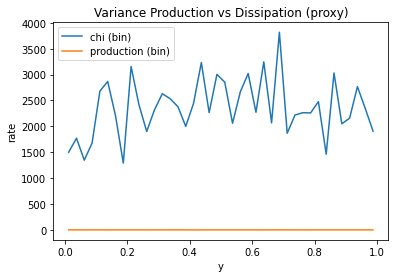

In [65]:
D = 1e-3  # small molecular diffusivity
dcdy_local = np.gradient(c_p_loc, y)
chi_local = 2*D*(dcdy_local**2)
chi_b = bin_mean(chi_local, y, bins)
# Local gradient of c' using nearest-neighbor finite difference on the raw data (noisy but illustrative)


# Production of variance P_c = -<v'c'> d\bar c/dy (bin)
P_b = -vc_b * dc_dy_b

fig = plt.figure(figsize=(6,4))
plt.plot(centers, chi_b, label="chi (bin)")
plt.plot(centers, P_b, label="production (bin)")
plt.xlabel("y"); plt.ylabel("rate"); plt.title("Variance Production vs Dissipation (proxy)"); plt.legend(); plt.show()

## 3.8 Example NB3.3: Demo for shear-mixing with eddy viscosity


**Learning goal:** Time/length-scale estimate for \(K_t\).

**Explanation:** Build $$(K_t\approx u'_{\rm rms}\,\ell)$$ and $$(K_t\approx u'^2_{\rm rms}\,\tau)$$ and compare to GD.

- $$\text{Grid and inputs: } y\in[0,L],\ n\ \text{points;\ sliders set } (\kappa, y_0, \text{wall\_damp}, u_\tau, \nu, A^+, m, \text{shear\_profile}, S_0, \text{decay}, \text{const\_S}, \mathrm{Pr}_t, (dT/dy)_0).$$

- $$\text{Mixing length: } 
\ell_m(y) = 
\begin{cases}
\kappa\,y_0 + \kappa\,(y-y_0)_+ , & \text{linear (offset } y_0\text{)}\\[4pt]
\kappa\,y\,\big(1 - e^{-\,y u_\tau/(\nu A^+)}\big)^{m}, & \text{Van Driest damping if wall\_damp = True}
\end{cases}$$

- $$\text{Shear profile: }\ 
S(y)\equiv \dfrac{dU}{dy} =
\begin{cases}
S_0\,e^{-y/\text{decay}}, & \text{Exponential decay}\\[4pt]
\text{const\_S}, & \text{Constant}
\end{cases}$$

- $$\text{Eddy viscosity (mixing-length closure): }\ \nu_t(y)=\ell_m(y)^2\,|S(y)|.$$

- $$\text{Eddy diffusivity via turbulent Prandtl: }\ \kappa_t(y)=\nu_t(y)/\mathrm{Pr}_t.$$

- $$\text{Imposed mean scalar gradient: }\ \dfrac{dT}{dy}(y)= (dT/dy)_0\,\big(1-y/L\big)\ \ \Rightarrow\ \ \text{strongest at } y=0,\ \text{vanishing at } y=L.$$

- $$\text{Turbulent scalar flux: }\ q_y(y)= -\,\kappa_t(y)\,\dfrac{dT}{dy}(y)\ \ \text{(down–gradient mixing).}$$

- $$\text{Scalar–variance production: }\ P_\theta(y)= 2\,\kappa_t(y)\,\Big(\dfrac{dT}{dy}(y)\Big)^2\ \ \text{(positive–definite source for } \langle \theta'^2\rangle\text{).}$$

- $$\text{Plots: }\ \ell_m(y)\ (\text{mixing length}),\ S(y)\ (\text{shear}),\ \nu_t(y)\ (\text{eddy viscosity}),\ \kappa_t(y)\ (\text{eddy diffusivity}),\ q_y(y)\ (\text{scalar flux}),\ P_\theta(y)\ (\text{variance production}).$$

- $$\text{Interpretation: increasing } \kappa,\ u_\tau \ \text{or decreasing }\nu\ \Rightarrow\ \text{larger } \ell_m,\ \nu_t,\ \kappa_t;\ \text{stronger } S(y)\ \Rightarrow\ \text{larger transport.}$$

- $$\text{Stability note: Van Driest damping enforces } \ell_m\!\to 0 \text{ as } y\!\to 0 \Rightarrow \nu_t\!\to 0 \text{ near the wall (physical wall behavior).}$$



In [66]:
def shear_demo(L=1.0, n=200, kappa=0.41, y0=0.0, wall_damp=False, u_tau=0.05, nu=1.5e-5, A_plus=26.0, m=1,
               shear_profile='Exponential decay', S0=20.0, decay=0.3, const_S=15.0, Pr_t=0.9, dTdy0=-40.0):
    y = np.linspace(0, L, int(n))
    lm = ch3.van_driest_damping(y,u_tau,nu,A_plus,kappa,m) if wall_damp else ch3.mixing_length_linear(y,kappa,y0)
    dUdy = S0*np.exp(-y/decay) if shear_profile=='Exponential decay' else np.full_like(y,const_S)
    nu_t = ch3.eddy_viscosity(lm, dUdy)
    kappa_t = ch3.eddy_diffusivity(nu_t, Pr_t)
    dTdy = dTdy0*(1 - y/L)
    q_y = -kappa_t*dTdy
    P_theta = 2.0*kappa_t*(dTdy**2)

    plt.figure(); plt.plot(y, lm); plt.xlabel("y"); plt.ylabel("ℓ_m (m)"); plt.title("Mixing length"); plt.show()
    plt.figure(); plt.plot(y, dUdy); plt.xlabel("y"); plt.ylabel("S (1/s)"); plt.title("Shear"); plt.show()
    plt.figure(); plt.plot(y, nu_t); plt.xlabel("y"); plt.ylabel("ν_t (m²/s)"); plt.title("Eddy viscosity"); plt.show()
    plt.figure(); plt.plot(y, kappa_t); plt.xlabel("y"); plt.ylabel("κ_t (m²/s)"); plt.title("Eddy diffusivity"); plt.show()
    plt.figure(); plt.plot(y, q_y); plt.xlabel("y"); plt.ylabel("q_y"); plt.title("Scalar flux"); plt.show()
    plt.figure(); plt.plot(y, P_theta); plt.xlabel("y"); plt.ylabel("P_θ"); plt.title("Scalar-variance production"); plt.show()

interact(
    shear_demo,
    L=FloatSlider(value=1.0, min=0.2, max=5.0, step=0.1, description="L"),
    n=IntSlider(value=200, min=50, max=800, step=10, description="n"),
    kappa=FloatSlider(value=0.41, min=0.2, max=0.6, step=0.01, description="κ"),
    y0=FloatSlider(value=0.0, min=0.0, max=0.1, step=0.005, description="y0"),
    wall_damp=Dropdown(options=[False, True], value=False, description="Van Driest"),
    u_tau=FloatSlider(value=0.05, min=0.01, max=0.5, step=0.01, description="u_τ"),
    nu=FloatSlider(value=1.5e-5, min=1e-6, max=5e-5, step=1e-6, description="ν"),
    A_plus=FloatSlider(value=26.0, min=5.0, max=40.0, step=1.0, description="A⁺"),
    m=IntSlider(value=1, min=1, max=2, step=1, description="m"),
    shear_profile=Dropdown(options=['Exponential decay','Constant'], value='Exponential decay', description='Shear'),
    S0=FloatSlider(value=20.0, min=1.0, max=50.0, step=1.0, description="S0"),
    decay=FloatSlider(value=0.3, min=0.05, max=1.5, step=0.05, description="decay"),
    const_S=FloatSlider(value=15.0, min=1.0, max=50.0, step=1.0, description="S const"),
    Pr_t=FloatSlider(value=0.9, min=0.5, max=1.5, step=0.05, description="Pr_t"),
    dTdy0=FloatSlider(value=-40.0, min=-200.0, max=0.0, step=5.0, description="∂T/∂y@0")
);

interactive(children=(FloatSlider(value=1.0, description='L', max=5.0, min=0.2), IntSlider(value=200, descript…


## 3.9. Example NB 3.4. $$\text{Van Driest damped mixing length vs.} \kappa_y \text{impact on } \nu_t$$

**Learning goal:** Use a near-wall damping of the mixing length to see how the eddy viscosity changes under different shear choices.

**What this cell defines**

$$
\ell_m^{\text{VD}}(y)
= \kappa\,y \,\Big(1 - e^{-\,y^{+}/A^{+}}\Big)^{m},
\qquad
y^{+}=\dfrac{y\,u_{\tau}}{\nu}.
$$

$$
\ell_m^{\text{lin}}(y)=\kappa\,y.
$$

$$
S(y)=\dfrac{dU}{dy} \;=\;
\begin{cases}
S_0, & \text{Constant shear}\\[6pt]
S_0\,e^{-\,y/\text{decay}}, & \text{Exponential shear}
\end{cases}
$$

$$
\nu_t(y) \;=\; \ell_m(y)^{2}\,|S(y)|.
$$

**How to read the plots / sliders**

- $$
\text{Near wall: } \ell_m^{\text{VD}}\!\to 0 \text{ as } y^{+}\!\to 0
\ \Rightarrow\ 
\nu_t \to 0\ \text{(physically consistent wall behavior).}
$$

- $$
A^{+}\!:\ \text{larger } A^{+} \Rightarrow \text{weaker damping (slower decay factor) } \Rightarrow
\text{larger } \ell_m^{\text{VD}} \text{ and } \nu_t \text{ near the wall.}
$$

- $$
u_{\tau},\,\nu:\ \ y^{+}=y\,u_{\tau}/\nu.\ 
\text{Higher } u_{\tau} \text{ or lower } \nu \Rightarrow \text{larger } y^{+}\ \Rightarrow
\text{damping lifts sooner.}
$$

- $$
\text{Shear choice: } 
\begin{cases}
\text{Constant } S: \ \nu_t \propto \ell_m^{2} \ (\text{differences show up near wall}),\\[4pt]
\text{Exponential } S: \ \nu_t \text{ may peak at intermediate } y\ \text{(balance of }\ell_m^2\text{ growth and }S\text{ decay).}
\end{cases}
$$

- $$
\kappa:\ \text{larger } \kappa \Rightarrow \text{larger } \ell_m \Rightarrow \text{larger } \nu_t.
\qquad
m:\ \text{controls damping sharpness (}m{=}1\ \text{standard; }m{=}2\ \text{stronger near-wall damping).}
$$

**Note**
$$
\text{The code uses }\ \nu_t=\ell_m^2\,|S|\ \text{ via a helper }\ \texttt{eddy viscosity}(\ell_m, S).
\ \text{Ensure your import/alias matches the helper module you’re using.}
$$


In [67]:
def vd_ell_m(y, kappa=0.41, u_tau=0.05, nu=1.5e-5, A_plus=26.0, m=1):
    y = np.asarray(y); y_plus = y*u_tau/nu
    return kappa*y*(1.0 - np.exp(-y_plus/A_plus))**m

def demo_vd(L=0.1, n=400, kappa=0.41, u_tau=0.05, nu=1.5e-5, A_plus=26.0, m=1,
            shear='Constant', S0=500.0, decay=0.02):
    y = np.linspace(0, L, int(n))
    lm_linear = kappa*y
    lm_vd = vd_ell_m(y, kappa, u_tau, nu, A_plus, m)
    dUdy = np.full_like(y, S0) if shear=='Constant' else S0*np.exp(-y/decay)
    nu_t_linear = ch3.eddy_viscosity(lm_linear, dUdy)
    nu_t_vd     = ch3.eddy_viscosity(lm_vd, dUdy)
    plt.figure(); plt.plot(y, lm_linear, label="ℓ_m=κy"); plt.plot(y, lm_vd, label="Van Driest"); plt.xlabel("y"); plt.ylabel("ℓ_m"); plt.title("Mixing length"); plt.legend(); plt.show()
    plt.figure(); plt.semilogy(y, np.maximum(nu_t_linear,1e-12), label="ν_t (κy)"); plt.semilogy(y, np.maximum(nu_t_vd,1e-12), label="ν_t (VD)"); plt.xlabel("y"); plt.ylabel("ν_t"); plt.title("Eddy viscosity"); plt.legend(); plt.show()

interact(
    demo_vd,
    L=FloatSlider(value=0.1, min=0.02, max=0.5, step=0.01, description="L (m)"),
    n=IntSlider(value=400, min=100, max=1200, step=50, description="n"),
    kappa=FloatSlider(value=0.41, min=0.2, max=0.6, step=0.01, description="κ"),
    u_tau=FloatSlider(value=0.05, min=0.01, max=0.5, step=0.01, description="u_τ"),
    nu=FloatSlider(value=1.5e-5, min=5e-7, max=5e-5, step=5e-7, description="ν"),
    A_plus=FloatSlider(value=26.0, min=10.0, max=40.0, step=1.0, description="A⁺"),
    m=IntSlider(value=1, min=1, max=2, step=1, description="m"),
    shear=Dropdown(options=['Constant','Exponential'], value='Constant', description='Shear'),
    S0=FloatSlider(value=500.0, min=50.0, max=2000.0, step=50.0, description="S₀"),
    decay=FloatSlider(value=0.02, min=0.005, max=0.2, step=0.005, description="decay"),
);

interactive(children=(FloatSlider(value=0.1, description='L (m)', max=0.5, min=0.02, step=0.01), IntSlider(val…

### 3.10 Example NB 3.5: Solve Scalar Diffusion Equation 
**Learning goal:** Visualize scalar-mixing diagnostics.

**Explanation:** Plot profiles to compare means, fluxes, and model estimates for interpretation.

$$\frac{d}{dy}\!\mu_{\mathrm{eff}}(y)\,\frac{d\phi}{dy}=0,
\qquad \phi(0)=\phi_0,\ \ \phi(L)=\phi_1,$$
#where $$\phi\$$ is either (U (mean velocity) or (\theta\) (temperature).

#Finite-volume / second-order stencil (cell \(i\)) with harmonic face values:
$$\mu_{w}=\frac{2\,\mu_{i-1}\mu_i}{\mu_{i-1}+\mu_i},\qquad
\mu_{e}=\frac{2\,\mu_{i}\mu_{i+1}}{\mu_{i}+\mu_{i+1}},
$$

$$
\frac{\mu_w}{\Delta y^2}\,\phi_{i-1}
-\frac{\mu_w+\mu_e}{\Delta y^2}\,\phi_{i}
+\frac{\mu_e}{\Delta y^2}\,\phi_{i+1}=0.
$$
#Dirichlet BCs are enforced by setting the first/last rows to identity with RHS \(\phi_0,\phi_1\).


#### 2) Mean momentum with eddy viscosity
#We close the mean shear flow via a mixing-length eddy viscosity:
$$
\frac{d}{dy}\!\Big((\nu+\nu_t)\,\frac{dU}{dy}\Big)=0,\qquad
\nu_t=\ell_m^2\,\bigg|\frac{dU}{dy}\bigg|.
$$
#Simple wall-distance mixing length:
$$
\ell_m=\kappa\,y \quad \text{(or for two walls: } \ell_m=\kappa\,y\,(1-y/L)\text{)}.
$$

#fixed-point iteration:
#1. Start with a guess \(U^{(0)}(y)\) (linear between \(U_0,U_1\)).
#2. Given \(U^{(k)}\), compute
   $$
   \left(\frac{dU}{dy}\right)^{(k)},\quad
   \nu_t^{(k)}=\ell_m^2\,\big|\,(dU/dy)^{(k)}\big|,\quad
   \mu_{\mathrm{eff}}^{(k)}=\nu+\nu_t^{(k)}.
   $$
#3 Solve
   $$
   \frac{d}{dy}\!\Big(\mu_{\mathrm{eff}}^{(k)}\,\frac{dU^{\star}}{dy}\Big)=0,
   \quad U^{\star}(0)=U_0,\ U^{\star}(L)=U_1.
   $$
#4. Under-relax:
   $$
   U^{(k+1)}=\omega\,U^{\star}+(1-\omega)\,U^{(k)},\qquad 0<\omega\le 1.
   $$
#5. Stop when \(\|U^{(k+1)}-U^{(k)}\|_\infty<\varepsilon\).

---

#### 3) Temperature (scalar) with eddy diffusivity                 
$$\kappa_t=\nu_t/\mathrm{Pr}_t, \alpha_{\mathrm{eff}}=\alpha+\kappa_t$$
$$
\frac{d}{dy}\!\Big(\alpha_{\mathrm{eff}}(y)\,\frac{d\theta}{dy}\Big)=0,
\qquad \theta(0)=T_0,\ \ \theta(L)=T_1.
$$


#### 4) What each plot shows
#### Mean velocity
$$U(y)$$  
#### mean shear
$$dU/dy$$  
#### Eddy viscosity
$$\nu_t(y)$$  
#### mean temperature
$$\theta(y)$$ .

#Notes:Choose 
                              
$$(\mathrm{Pr}_t\approx 0.85\text{–}0.9\) $$ 
#for air (adjust per flow). Apply small caps to \(\ell_m\) or \(\nu_t\) if needed for stability.


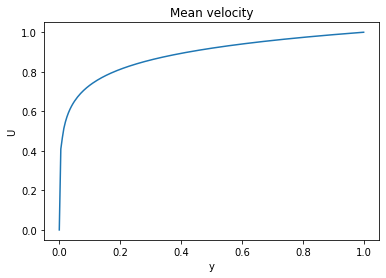

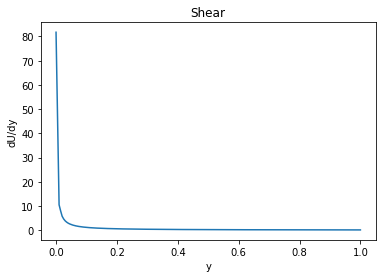

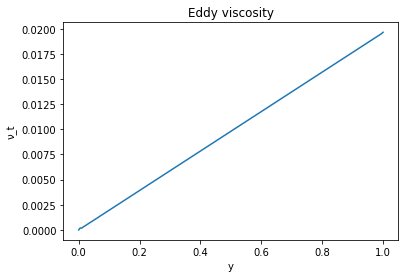

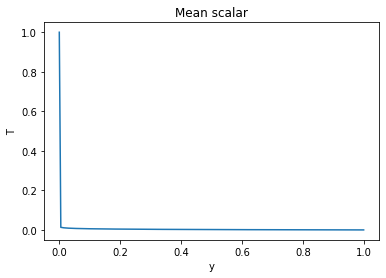

In [68]:
def solve_steady_diffusion(y, mu_eff, bc0, bc1):
    y = np.asarray(y); mu = np.asarray(mu_eff); n = len(y); dy = y[1]-y[0]
    A = np.zeros((n,n)); b = np.zeros(n); A[0,0]=1; b[0]=bc0; A[-1,-1]=1; b[-1]=bc1
    for i in range(1,n-1):
        mu_w = 2*mu[i-1]*mu[i]/(mu[i-1]+mu[i]); mu_e = 2*mu[i]*mu[i+1]/(mu[i]+mu[i+1])
        A[i,i-1]= mu_w/(dy*dy); A[i,i]=-(mu_w+mu_e)/(dy*dy); A[i,i+1]= mu_e/(dy*dy)
    return np.linalg.solve(A,b)

def momentum_scalar_solver(n=201, L=1.0, nu=1.5e-5, alpha=1.4e-7, kappa=0.41, Pr_t=0.9,
                           U0=0.0, U1=1.0, T0=1.0, T1=0.0, max_iter=30):
    y = np.linspace(0, L, int(n)); U = np.linspace(U0, U1, int(n))
    for _ in range(int(max_iter)):
        dUdy = np.gradient(U, y); lm = kappa*y; nu_t = (lm**2)*np.abs(dUdy); mu_eff = nu + nu_t
        U_new = solve_steady_diffusion(y, mu_eff, U0, U1)
        if np.max(np.abs(U_new-U))<1e-6: U=U_new; break
        U = 0.5*U + 0.5*U_new
    kappa_t = nu_t/Pr_t; alpha_eff = alpha + kappa_t; T = solve_steady_diffusion(y, alpha_eff, T0, T1)
    plt.figure(); plt.plot(y,U); plt.xlabel("y"); plt.ylabel("U"); plt.title("Mean velocity"); plt.show()
    plt.figure(); plt.plot(y,np.gradient(U,y)); plt.xlabel("y"); plt.ylabel("dU/dy"); plt.title("Shear"); plt.show()
    plt.figure(); plt.plot(y,nu_t); plt.xlabel("y"); plt.ylabel("ν_t"); plt.title("Eddy viscosity"); plt.show()
    plt.figure(); plt.plot(y,T); plt.xlabel("y"); plt.ylabel("T"); plt.title("Mean scalar"); plt.show()

momentum_scalar_solver()


### 3.11. Example NB 3.6. — Buoyancy & Shear Demo (stability vs eddy mixing)

**Learning goal:** Explore how background stratification (via \(N^2\)) and mean shear \(S=\partial_y U\) control the gradient Richardson number and the eddy diffusivity \(\kappa_t\).

**What this cell does:**

- Builds a 1-D vertical grid \(y\in[0,L]\) with \(n\) points.
- Prescribes an exponential shear profile:
  $$
  S(y) \equiv \frac{dU}{dy} \;=\; S_0\,e^{-\,y/\text{decay}}.
  $$
- Uses a wall-distance mixing length:
  $$
  \text{mixing-length: }\ \ell_m=\kappa\,y.
  $$
- Forms eddy viscosity and eddy (thermal) diffusivity:
  $$
  \nu_t \;=\; \ell_m^{\,2}\,|S|, 
  \qquad
  \kappa_t \;=\; \frac{\nu_t}{\mathrm{Pr}_t}.
  $$
- Prescribes a buoyancy-frequency (stratification) profile:
  $$
  N^2(y) \;=\; N^2_0 \;+\; N^2_{\text{slope}}\,(y - L/2),
  $$
  where \(N^2>0\) is stably stratified and \(N^2<0\) is convectively unstable.
- Computes the gradient Richardson number:
  $$
  \mathrm{Ri}_g(y) \;=\; \frac{N^2(y)}{S(y)^2 + \epsilon},
  \qquad \epsilon\ll 1.
  $$
- Plots three diagnostics vs \(y\): \(N^2(y)\), \(\mathrm{Ri}_g(y)\), and \(\kappa_t(y)\).

**How to read the plots / sliders:**

$$
\text{S}_0,\ \text{decay: }\ \text{larger shear or slower decay } \Rightarrow \text{ smaller }\mathrm{Ri}_g\ \text{ (mixing more likely); }\ 
\kappa_t\ \text{ increases because it scales with } |S|.
$$

$$
N^2_0,\ \text{N2\_slope: }\ \text{stronger stable stratification } \Rightarrow \text{ larger }\mathrm{Ri}_g\ \text{ and typically suppressed mixing (this simple model does not yet damp }\kappa_t\text{ by }\mathrm{Ri}_g\text{).}
$$

$$
\kappa\ \text{(von K\'arm\'an): increases the mixing length }\ell_m\ \Rightarrow\ \text{larger } \nu_t \text{ and } \kappa_t.
$$

$$
\mathrm{Pr}_t:\ \text{sets the ratio } \nu_t/\kappa_t;\ \text{higher }\mathrm{Pr}_t \Rightarrow \text{smaller }\kappa_t \text{ for the same } \nu_t.
$$

**Notes / extensions:**

$$
\text{Units: } S\,[\mathrm{s}^{-1}],\quad N^2\,[\mathrm{s}^{-2}],\quad \nu_t,\ \kappa_t\,[\mathrm{m}^2/\mathrm{s}].
$$


In [69]:
from ipywidgets import interact
def buoy_demo(L=1.0, n=300, S0=10.0, decay=0.4, N2_0=0.02, N2_slope=0.0, Pr_t=0.9, kappa=0.41):
    y = np.linspace(0, L, int(n)); dUdy = S0*np.exp(-y/decay); lm = kappa*y; nu_t=(lm**2)*np.abs(dUdy); kappa_t=nu_t/Pr_t
    N2 = N2_0 + N2_slope*(y - L/2.0); Ri_g = N2/np.maximum(dUdy**2, 1e-12)
    plt.figure(); plt.plot(y,N2); plt.xlabel("y"); plt.ylabel("N²"); plt.title("Stability"); plt.show()
    plt.figure(); plt.plot(y,Ri_g); plt.xlabel("y"); plt.ylabel("Ri_g"); plt.title("Gradient Richardson"); plt.show()
    plt.figure(); plt.plot(y,kappa_t); plt.xlabel("y"); plt.ylabel("κ_t"); plt.title("Eddy diffusivity"); plt.show()

interact(
    buoy_demo,
    L=FloatSlider(value=1.0, min=0.2, max=5.0, step=0.1, description="L"),
    n=IntSlider(value=300, min=50, max=800, step=10, description="n"),
    S0=FloatSlider(value=10.0, min=0.5, max=40.0, step=0.5, description="S0"),
    decay=FloatSlider(value=0.4, min=0.05, max=2.0, step=0.05, description="decay"),
    N2_0=FloatSlider(value=0.02, min=-0.05, max=0.1, step=0.005, description="N² @ mid"),
    N2_slope=FloatSlider(value=0.0, min=-0.2, max=0.2, step=0.005, description="N² slope"),
    Pr_t=FloatSlider(value=0.9, min=0.5, max=1.5, step=0.05, description="Pr_t"),
    kappa=FloatSlider(value=0.41, min=0.2, max=0.6, step=0.01, description="κ"),
);

interactive(children=(FloatSlider(value=1.0, description='L', max=5.0, min=0.2), IntSlider(value=300, descript…

## 3.12 Example NB 3.7: Density Currents
**Learning goal:** Visualize buoyancy-driven density currents using eddy mixing concepts.


- $$\text{Domain/grid: } x\in[0,L],\ n\ \text{points.}$$

- $$\text{Reduced gravity: } g' = g\,\frac{\Delta\rho}{\rho_0} \quad(\text{Boussinesq approximation}).$$

- $$\text{Layer thickness with entrainment: } h(x)=h_0 + E\,x \quad(\text{entrainment coefficient } E\ge 0\ \text{deepens the current}).$$

- $$\text{Front/velocity scale (Froude): } U(x)=\mathrm{Fr}\,\sqrt{\,g'\,h(x)\,}\quad(\text{gravity current scaling}).$$

- $$\text{Dilution of scalar contrast: } \Delta C(x)=\Delta C_0\,\frac{h_0}{h(x)}\quad(\text{thicker layer } \Rightarrow \text{ weaker contrast}).$$

- $$\text{Shear scale: } S(x)\approx \frac{U(x)}{h(x)}\quad(\text{velocity change over layer thickness}).$$

- $$\text{Mixing length: } \ell_m(x)=\gamma\,h(x)\quad(\gamma \text{ is a constant fraction of thickness}).$$

- $$\text{Eddy viscosity: } \nu_t(x)=\ell_m(x)^2\,|S(x)|.$$

- $$\text{Eddy diffusivity (thermal/scalar): } \kappa_t(x)=\frac{\nu_t(x)}{\mathrm{Pr}_t}.$$

- $$\text{Interface thickness proxy: } \delta(x)=\gamma\,h(x).$$

- $$\text{Flux proxy (down–gradient): } q(x)= -\,\kappa_t(x)\,\frac{\Delta C(x)}{\max(\delta(x),\epsilon)}\quad(\epsilon\ll 1\ \text{for stability}).$$

**What the plots show:**  
- $$h(x)\ \text{(layer thickness)},\quad U(x)\ \text{(velocity scale)},\quad \Delta C(x)\ \text{(dilution)},\quad \kappa_t(x)\ \text{(eddy diffusivity)},\quad q(x)\ \text{(flux proxy)}.$$

**Slider intuition:**  
- $$\Delta\rho\ \text{ or smaller } \rho_0\ \Rightarrow\ \text{larger } g' \Rightarrow \text{larger } U \Rightarrow \text{larger } \kappa_t,\ q.$$
- $$E\ \uparrow \Rightarrow h\uparrow,\ \Delta C\downarrow\ (\text{dilution});\ \ell_m\propto h \Rightarrow \nu_t,\ \kappa_t\uparrow.$$
- $$\gamma\ \uparrow \Rightarrow \ell_m\uparrow,\ \delta\uparrow \Rightarrow \kappa_t\uparrow\ \text{but}\ \Delta C/\delta\downarrow\ (\text{two competing effects on } q).$$
- $$\mathrm{Fr}\ \uparrow \Rightarrow U\uparrow \Rightarrow S\uparrow \Rightarrow \nu_t,\ \kappa_t,\ q\uparrow.$$
- $$\mathrm{Pr}_t\ \uparrow \Rightarrow \kappa_t=\nu_t/\mathrm{Pr}_t\downarrow\ (\text{for fixed } \nu_t).$$

**Units:**  
- $$g'[\mathrm{m\,s^{-2}}],\ U[\mathrm{m\,s^{-1}}],\ S[\mathrm{s^{-1}}],\ \nu_t,\kappa_t[\mathrm{m^2\,s^{-1}}],\ h,\delta[\mathrm{m}].$$


In [70]:
from ipywidgets import FloatSlider, IntSlider
g = 9.81
def density_current_demo(L=200.0, n=400, rho0=1000.0, drho=2.0, h0=0.5, Fr=0.9, E=0.02, kappa=0.41, gamma=0.1, Pr_t=0.9):
    x = np.linspace(0, L, int(n)); h = h0 + E*x; gprime = g*(drho/rho0); U = Fr*np.sqrt(np.maximum(gprime*h, 1e-12))
    DeltaC0 = 1.0; DeltaC = DeltaC0*(h0/h); S = np.maximum(U/np.maximum(h,1e-12),1e-12); ell_m = gamma*h
    nu_t=(ell_m**2)*S; kappa_t=nu_t/Pr_t; delta = gamma*h; q = -kappa_t*(DeltaC/np.maximum(delta,1e-12))
    plt.figure(); plt.plot(x,h); plt.xlabel("x"); plt.ylabel("h"); plt.title("Layer thickness"); plt.show()
    plt.figure(); plt.plot(x,U); plt.xlabel("x"); plt.ylabel("U"); plt.title("Front speed scale"); plt.show()
    plt.figure(); plt.plot(x,DeltaC); plt.xlabel("x"); plt.ylabel("ΔC"); plt.title("Dilution"); plt.show()
    plt.figure(); plt.plot(x,kappa_t); plt.xlabel("x"); plt.ylabel("κ_t"); plt.title("Eddy diffusivity"); plt.show()
    plt.figure(); plt.plot(x,q); plt.xlabel("x"); plt.ylabel("q"); plt.title("Flux proxy"); plt.show()
interact(density_current_demo,
         L=FloatSlider(value=200.0, min=20.0, max=2000.0, step=10.0, description="L"),
         n=IntSlider(value=400, min=100, max=2000, step=50, description="n"),
         rho0=FloatSlider(value=1000.0, min=900.0, max=1030.0, step=1.0, description="ρ0"),
         drho=FloatSlider(value=2.0, min=0.1, max=20.0, step=0.1, description="Δρ"),
         h0=FloatSlider(value=0.5, min=0.05, max=5.0, step=0.05, description="h0"),
         Fr=FloatSlider(value=0.9, min=0.2, max=1.5, step=0.05, description="Fr"),
         E=FloatSlider(value=0.02, min=0.0, max=0.2, step=0.005, description="E"),
         kappa=FloatSlider(value=0.41, min=0.2, max=0.6, step=0.01, description="κ"),
         gamma=FloatSlider(value=0.1, min=0.02, max=0.5, step=0.01, description="γ"),
         Pr_t=FloatSlider(value=0.9, min=0.5, max=2.0, step=0.05, description="Pr_t"),
);

interactive(children=(FloatSlider(value=200.0, description='L', max=2000.0, min=20.0, step=10.0), IntSlider(va…

### 3.13. Example NB 3.8: Eddy mixing time scale

- $$\text{Preconditions: we need arrays } y,u,c \text{ and (if not present) we build } \text{bins,idx} \text{ so each sample maps to a } y\text{-bin.}$$

- $$\text{Bin centers: } \text{centers}=\tfrac12(\text{bins}_{k}+\text{bins}_{k+1}).$$

- $$\text{Bin means: } \langle u\rangle_k=\text{bin\_mean}(u,y,\text{bins}),\quad \langle c\rangle_k=\text{bin\_mean}(c,y,\text{bins}).$$

- $$\text{Local fluctuations (per sample, around its bin mean): } u'_i=u_i-\langle u\rangle_{\text{idx}_i},\ \ c'_i=c_i-\langle c\rangle_{\text{idx}_i}.$$

- $$\text{Velocity scale per bin: } u'_{\text{rms},k}=\sqrt{\langle {u'}^2\rangle_k}=\sqrt{\text{bin\_mean}(u'^2,y,\text{bins})}.$$

- $$\text{Shear time scale: } \tau_S(k)=\frac{1}{\left|\,\partial_y\langle u\rangle\,\right|_k},\ \ \partial_y\langle u\rangle\approx \text{gradient}(\langle u\rangle,\text{centers}),\ \ \text{with a small floor } 10^{-8}\ \text{for stability.}$$

- $$\text{Illustrative mixing length (center-peaked toy): } \ell_k = 0.1+0.2\Big(1-\frac{(\text{centers}_k-\overline{y})^2}{(\tfrac12\,\text{ptp}(y)+10^{-12})^2}\Big).$$

- $$\text{Time-scale eddy diffusivity candidates: } K_t^{(1)}(k)\approx u'_{\text{rms},k}\,\ell_k,\quad K_t^{(2)}(k)\approx u_{\text{rms},k}^{\;2}\,\tau_S(k).$$

- $$\text{If needed, build turbulent scalar flux: } \langle v'c'\rangle_k=\text{bin\_mean}\big((v-\langle v\rangle_{\text{idx}})\,(c-\langle c\rangle_{\text{idx}}),\,y,\,\text{bins}\big).$$

- $$\text{Mean scalar gradient per bin: } (\partial_y\langle c\rangle)_k \approx \text{gradient}(\langle c\rangle,\text{centers}).$$

- $$\text{Gradient–diffusion estimate (reference): } K_t^{(\text{GD})}(k)= -\,\dfrac{\langle v'c'\rangle_k}{(\partial_y\langle c\rangle)_k}\ \ \text{with a } 10^{-8}\ \text{denominator floor.}$$

- $$\text{Plot: compare } K_t^{(\text{GD})}\ \text{(from data/closure)}\ \text{against } K_t^{(1)} \text{ and } K_t^{(2)} \text{ (from time/length-scale arguments).}$$

- $$\text{Interpretation: if } K_t^{(1)} \text{ or } K_t^{(2)} \text{ matches the trend of } K_t^{(\text{GD})},\ \text{the chosen } \ell \text{ or } \tau \text{ captures the mixing physics; magnitudes can be tuned by a constant if desired.}$$


###   Picking mixing length

- $$
\text{Goal: make a smooth, center-peaked } \ell_m(y) \text{ on } [y_{\min},y_{\max}] \text{ that vanishes near the ends and is largest at the center.}
$$

- $$
\text{Let } \bar{y}=\tfrac{1}{2}(y_{\min}+y_{\max}),\quad a=\tfrac{1}{2}(y_{\max}-y_{\min}).
$$

- $$
\text{Use a simple “bump” shape } \phi(y)=1-\Big(\tfrac{y-\bar{y}}{a}\Big)^2 \ \ (\text{parabolic, peak } \phi(\bar{y})=1,\ \text{ends } \phi(y_{\min/\max})=0).
$$

- $$
\text{Then scale/offset it so it’s never zero: } 
\ell_m(y)=\ell_0+\ell_1\,\phi(y)
\quad\Rightarrow\quad
\ell_m(y)=0.1 + 0.2\bigg[1-\frac{(y-\bar{y})^2}{a^2+10^{-12}}\bigg].
$$

- $$
\text{This was purely illustrative to show “time-scale” ideas; it is not a model you must use.}
$$


### How to get the time scales 

**Core ideas**

- $$
\text{Shear time scale (most common): }\quad
\tau_S(y) \;=\; \frac{1}{\left|\,\partial_y\langle U\rangle(y)\,\right|}.
$$

- $$
\text{Mixing-length time scale: }\quad
\tau_\ell(y) \;=\; \frac{\ell_m(y)}{u'_{\text{rms}}(y)}.
$$

- $$
\text{Turbulence (}k\text{-}\varepsilon\text{) time scale: }\quad
\tau_{k\varepsilon}(y) \;=\; \frac{k(y)}{\varepsilon(y)}\quad
\text{(requires }k,\varepsilon\text{).}
$$

- $$
\text{From eddy diffusivity and velocity scale: }\quad
\tau_K(y) \;=\; \frac{K_t(y)}{u'_{\text{rms}}(y)^{2}}
\quad\text{if }K_t\text{ and }u'_{\text{rms}}\text{ are known.}
$$

- $$
\text{From data correlations (optional): }\quad
\tau_{\text{int}} \;=\; \int_0^\infty R_{uu}(\Delta t)\,d\Delta t
\ \ \text{or}\ \
\tau_{\text{peak}}\approx \frac{1}{\omega_{\text{peak}}}\ \text{from spectra.}
$$

**Practical in this notebook**

- $$
\text{We typically use } \tau_S = 1/\left|\,\partial_y\langle U\rangle\,\right|
\ \text{ or }\
\tau_\ell = \ell_m/u'_{\text{rms}},
\ \text{depending on what profiles are available.}
$$

**Numerical tips**

- $$
\text{Always smooth } \langle U\rangle(y)\ \text{lightly before differentiating to reduce noise.}
$$
- $$
\text{Clip floors to avoid blow-up: } \left|\,\partial_y\langle U\rangle\,\right|\ge 10^{-8},\ u'_{\text{rms}}\ge 10^{-8}.
$$
- $$
\text{Units check: } \tau\ [\text{s}],\ \ \partial_y\langle U\rangle\ [\text{s}^{-1}],\ \ \ell_m/u'_{\text{rms}}\ [\text{s}].
$$

---



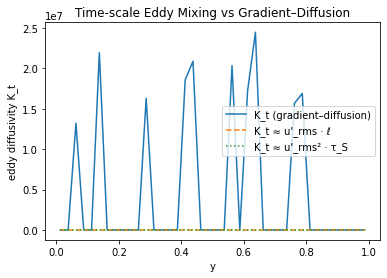

In [79]:
# --- Time-scale eddy mixing examples ---
import numpy as np
import matplotlib.pyplot as plt

# Preconditions: we expect to have y, u, c, bins, idx, and bin-averaged results from earlier cells.
# We'll defensively recompute what we need if missing.

# Ensure y, u, c are numpy arrays
y = np.asarray(y).reshape(-1)
u = np.asarray(u).reshape(-1)
c = np.asarray(c).reshape(-1)

# Ensure bins/idx exist
if 'bins' not in globals():
    num_bins = 60
    bins = np.linspace(y.min(), y.max(), num_bins+1)
if 'idx' not in globals():
    idx = np.searchsorted(bins, y, side='right') - 1
    idx = np.clip(idx, 0, len(bins)-2)

# Ensure we have bin means of u and c
if 'u_re_b' not in globals():
    u_re_b = bin_mean(u, y, bins)
if 'c_re_b' not in globals():
    c_re_b = bin_mean(c, y, bins)

centers = 0.5*(bins[:-1] + bins[1:])

# Local fluctuations around bin means
u_p_loc = u - u_re_b[idx]
c_p_loc = c - c_re_b[idx]

# Bin RMS of u' as a surrogate turbulent velocity scale
up2_b = bin_mean(u_p_loc*u_p_loc, y, bins)
u_rms_b = np.sqrt(np.maximum(up2_b, 0))

# Shear time scale tau_S = 1 / |d<U>/dy| (bin-wise)
dUdy_b = np.gradient(u_re_b, centers)
tau_S = 1.0 / np.maximum(np.abs(dUdy_b), 1e-8)

# Simple mixing length profile (center-peaked, illustrative)
ell_b = 0.1 + 0.2*(1 - (centers - centers.mean())**2 / (centers.ptp()/2 + 1e-12)**2)

# Time-scale eddy diffusivity candidates
Kt_tau1 = u_rms_b * ell_b                 # Kt ≈ u'_rms * ell
Kt_tau2 = (u_rms_b**2) * tau_S            # Kt ≈ u'_rms^2 * tau

# If we already have gradient–diffusion estimate Kt_est, bring it; otherwise build it now
if 'vc_b' not in globals():
    # Need turbulent scalar flux and mean scalar gradient (bin-based)
    # Recompute v if missing; otherwise assume v exists.
    if 'v' not in globals():
        v = 0.4*np.random.randn(len(y))
    v_re_b = bin_mean(v, y, bins)
    v_p_loc = v - v_re_b[idx]
    vc_b = bin_mean(v_p_loc*c_p_loc, y, bins)
dcdy_b = np.gradient(c_re_b, centers)
Kt_est = -vc_b / np.maximum(dcdy_b, 1e-8)

# Plot comparison
plt.figure(figsize=(6,4))
plt.plot(centers, Kt_est, label="K_t (gradient–diffusion)")
plt.plot(centers, Kt_tau1, '--', label="K_t ≈ u'_rms · ℓ")
plt.plot(centers, Kt_tau2, ':', label="K_t ≈ u'_rms² · τ_S")
plt.xlabel("y"); plt.ylabel("eddy diffusivity K_t")
plt.title("Time‑scale Eddy Mixing vs Gradient–Diffusion")
plt.legend(); plt.show()


In [81]:
## 3.13 Home work Problems
#**Learning goal:**  Assessment and Test problems

<a id="homework-eng"></a>
## 10*. Homework Problems

> Use data from your notebook where available (bin profiles, synthetic set, etc.).  
> If not, the problem provides nominal values. Show **units** and give a **concise engineering conclusion** for each.

---

### HW NB3.1 — Estimate of \(K_t\) from One Bin (Channel Core)

**Given:**  
At \(y = 0.5\,\text{m}\), you measured  
\[
\langle v'c'\rangle = -0.12~\text{kg·m/s}, \qquad
\frac{\partial \overline{c}}{\partial y} = 0.60~\text{kg/m}^4.
\]

**Task:**  
Compute the **eddy diffusivity**
\[
K_t = -\frac{\langle v'c'\rangle}{\partial_y \overline{c}}.
\]

**Deliverables:**  
- Value of \(K_t\) with correct units (m²/s)  
- One-line comment comparing its magnitude to typical lab or atmospheric values.

---

### HW NB3.2 — Choose \(\mathrm{Pr}_t\) to Match a Measured Heat Flux

**Given:**  
Measured wall-normal heat flux at \(y = 0.2\,\text{m}\):
\[
q_y = -25~\text{K·m/s}.
\]
From your model:
\[
\nu_t = 4.0\times10^{-3}~\text{m}^2/\text{s}, \quad
\frac{\partial \overline{T}}{\partial y} = 80~\text{K/m}.
\]

**Task:**  
Select the turbulent Prandtl number so that the modeled flux matches:
\[
q_y^{(\text{model})}
  = -\kappa_t\,\partial_y \overline{T}
  = -\frac{\nu_t}{\mathrm{Pr}_t}\,\partial_y \overline{T}
  \stackrel{!}{=}\ -25.
\]

**Deliverables:**  
- \(\mathrm{Pr}_t\) (dimensionless)  
- Comment if it lies in a realistic range (0.7–1.0 for air, ~0.85 for water).

---

### HW NB3.3 Compare Two \(K_t\) Estimates and Pick a Design Value

**Given:**  
In a mixing layer,  
\[
u'_{\text{rms}} = 0.25~\text{m/s}, \quad
\ell_m = 0.03~\text{m}, \quad
|\partial_y \overline{U}| = 4.5~\text{s}^{-1}.
\]

**Task:**  
Compute and compare:
\[
K_t^{(1)} = u'_{\text{rms}} \ell_m, \qquad
K_t^{(2)} = \frac{u_{\text{rms}}^2}{|\partial_y \overline{U}|}.
\]

Choose a design eddy diffusivity for 1-D transport as the geometric mean:
\[
K_t^{\text{design}} = \sqrt{K_t^{(1)} K_t^{(2)}}.
\]

**Deliverables:**  
- \(K_t^{(1)}, K_t^{(2)}, K_t^{\text{design}}\) (m²/s)  
- One-line justification of why the geometric mean is robust.

---

### HW NB3.4  Height Where \(\nu_t = \nu\) (Transition to Turbulent Dominance)

**Given:**  
\[
\nu = 1.5\times10^{-5}~\text{m}^2/\text{s}, \quad
\ell_m = \kappa y, \ \kappa = 0.41, \quad
S(y) = S_0 e^{-y/\lambda}, \ S_0 = 20~\text{s}^{-1}, \ \lambda = 0.08~\text{m}.
\]

**Task:**  
Find \(y_\times\) such that \(\nu_t(y_\times) = \nu\) with \(\nu_t = \ell_m^2 |S|\).

**Deliverables:**  
- \(y_\times\) (m)  
- Ratios \(\nu_t/\nu\) at \(0.5y_\times\) and \(2y_\times\)  
- One-line comment describing the “onset of turbulence.”

---

### HW NB3.5  Stability-Limited \(\kappa_t\) Using \(\mathrm{Ri}_g\)

**Given:**  
At \(y=0.3\,\text{m}\),
\[
N^2 = 0.08~\text{s}^{-2}, \quad
S = 0.9~\text{s}^{-1}, \quad
\kappa_t = 5.0\times10^{-3}~\text{m}^2/\text{s}.
\]

**Task:**  
Apply a stability correction:
\[
\kappa_t' = \frac{\kappa_t}{1 + 10\,\mathrm{Ri}_g}, \qquad
\mathrm{Ri}_g = \frac{N^2}{S^2}.
\]

**Deliverables:**  
- \(\mathrm{Ri}_g\) and corrected \(\kappa_t'\)  
- Short note on whether the flow is stable, marginal, or mixing-dominated.

---

### HW NB3.6 Gravity Current: Entrainment Coefficient from Dilution

**Given:**  
Gravity current over \(L=500\,\text{m}\).  
Measured thickness increases from \(h_0=1.0\,\text{m}\) to \(h_L=1.6\,\text{m}\).  
Assume \(h(x) = h_0 + E x\).

**Task:**  
Estimate the entrainment coefficient \(E\) and scalar dilution at the end:
\[
\Delta C(L) = \Delta C_0\,\frac{h_0}{h_L}, \qquad \Delta C_0 = 1.0.
\]

**Deliverables:**  
- \(E\) (m/m)  
- \(\Delta C(L)\) (dimensionless)  
- Comment on sensitivity if \(h_L = 1.8\,\text{m}\).

---

### HW NB3.7  Pick \(A^+\) to Match Measured \(\nu_t\) Near Wall (Van Driest)

**Given:**  
At \(y = 2\,\text{mm}\) in air:  
\[
u_\tau = 0.35~\text{m/s}, \quad
\nu = 1.5\times10^{-5}~\text{m}^2/\text{s}, \quad
\nu_t^{(\text{meas})} = 1.2\times10^{-4}~\text{m}^2/\text{s}.
\]
Model:
\[
\ell_m = \kappa y\Big(1 - e^{-y^+/A^+}\Big), \quad
y^+ = \frac{y u_\tau}{\nu}, \quad
\nu_t = \ell_m^2 |S|, \quad |S| = 45~\text{s}^{-1}, \ \kappa = 0.41.
\]

**Task:**  
Iterate or scan \(A^+ \in [10, 40]\) to find the value that matches \(\nu_t^{(\text{meas})}\).

**Deliverables:**  
- Chosen \(A^+\)  
- Percent error vs measurement  
- One-line comment on physical interpretation (wall damping strength).

---
